In [1]:
import os
import sys
import glob
import pickle
import tables

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from comet_ml.api import API, APIExperiment
from comet_ml.query import Tag

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

#### Find the best experiment given a set of tags

In [2]:
api = API(api_key = os.environ['COMET_API_KEY'])
workspace = 'danielelinaro'
project_name = 'inertia'
generator_IDs = [1, 2]
D = 2
DZA = 60
query = Tag('IEEE14') & \
        Tag('_'.join([f'G{gen_id}' for gen_id in generator_IDs])) & \
        Tag(f'D={D}') & \
        Tag(f'DZA={DZA}') & \
        Tag('1D_pipeline')
experiments = api.query(workspace, project_name, query, archived=False)
experiment_IDs = []
MAPE = []
val_loss = []
tags =  []
for experiment in experiments:
    ID = experiment.id
    experiment_IDs.append(ID)
    sys.stdout.write(f'Downloading data for experiment ID {ID}... ')
    metrics = experiment.get_metrics()
    sys.stdout.write('done.\n')
    val_loss.append(np.array([float(m['metricValue']) for m in metrics if m['metricName'] == 'val_loss']))
    has_MAPE = False
    for m in metrics:
        if m['metricName'] == 'mape_prediction':
            val = m['metricValue']
            try:
                MAPE.append(float(val))
            except:
                MAPE.append(list(map(float, [v for v in val[1:-1].split(' ') if len(v) > 0])))
            has_MAPE = True
            break
    tags.append(experiment.get_tags())
    print(f'  val_loss: {val_loss[-1].min():.4f}')
    if has_MAPE:
        print(f'      MAPE: {MAPE[-1]}%')
    else:
        print('      MAPE: [experiment not terminated]')
    print('      Tags: "{}"'.format('" "'.join(tags[-1])))
# idx = np.argmin(MAPE)
idx = np.argmin([loss.min() for loss in val_loss])
experiment_ID = experiment_IDs[idx]
MAPE = MAPE[idx]
val_loss = val_loss[idx]
tags = tags[idx]
print(f'The best experiment is {experiment_ID[:6]} (val_loss = {val_loss.min():.4f}, MAPE = {MAPE}%).')

  val_loss: 0.0300
      MAPE: [0.40709308, 0.63866687]%
      Tags: "1D_pipeline" "D=2" "DZA=60" "G1_G2" "IEEE14" "ReLU_none"
  val_loss: 0.0285
      MAPE: [0.37914744, 0.6245588]%
      Tags: "1D_pipeline" "D=2" "DZA=60" "exp_lr" "G1_G2" "IEEE14" "ReLU_none"
  val_loss: 0.0297
      MAPE: [0.6234043, 0.62713647]%
      Tags: "1D_pipeline" "cyclical_lr" "D=2" "DZA=60" "G1_G2" "IEEE14" "ReLU_none"
The best experiment is 87cd5e (val_loss = 0.0285, MAPE = [0.37914744, 0.6245588]%).


In [3]:
experiments_path = '../experiments/neural_network/'
checkpoint_path = experiments_path + experiment_ID + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
network_parameters = pickle.load(open(experiments_path + experiment_ID \
                                      + '/parameters.pkl', 'rb'))
epochs = [int(os.path.split(file)[-1].split('.')[1].split('-')[0]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[epochs.index(np.argmin(val_loss) + 1)]
model = keras.models.load_model(best_checkpoint, compile=True)
try:
    data_dirs = ['../' + network_parameters['data_dir']]
except:
    data_dirs = ['../' + data_dir.format(gen_id) for gen_id in network_parameters['generator_IDs'] \
                 for data_dir in network_parameters['data_dirs']]
# we need mean and standard deviation of the training set to normalize the data
x_train_mean = network_parameters['x_train_mean']
x_train_std  = network_parameters['x_train_std']
for i in range(len(data_dirs)):
    if not os.path.isdir(data_dirs[i]):
        path = ''
        for d in data_dirs[i].split(os.path.sep):
            path += d + os.path.sep
            if d == 'data':
                path += 'IEEE14' + os.path.sep
        data_dirs[i] = path
print('Loaded network from {}.'.format(best_checkpoint))
print('Data directories are {}.'.format(data_dirs))

Loaded network from ../experiments/neural_network/87cd5ece1b7044c0a783d9ba2de12607/checkpoints/weights.0982-0.028454.h5.
Data directories are ['../data/IEEE14/var_H_G1/IEEE14_D=2_DZA=60.0/', '../data/IEEE14/var_H_G2/IEEE14_D=2_DZA=60.0/'].


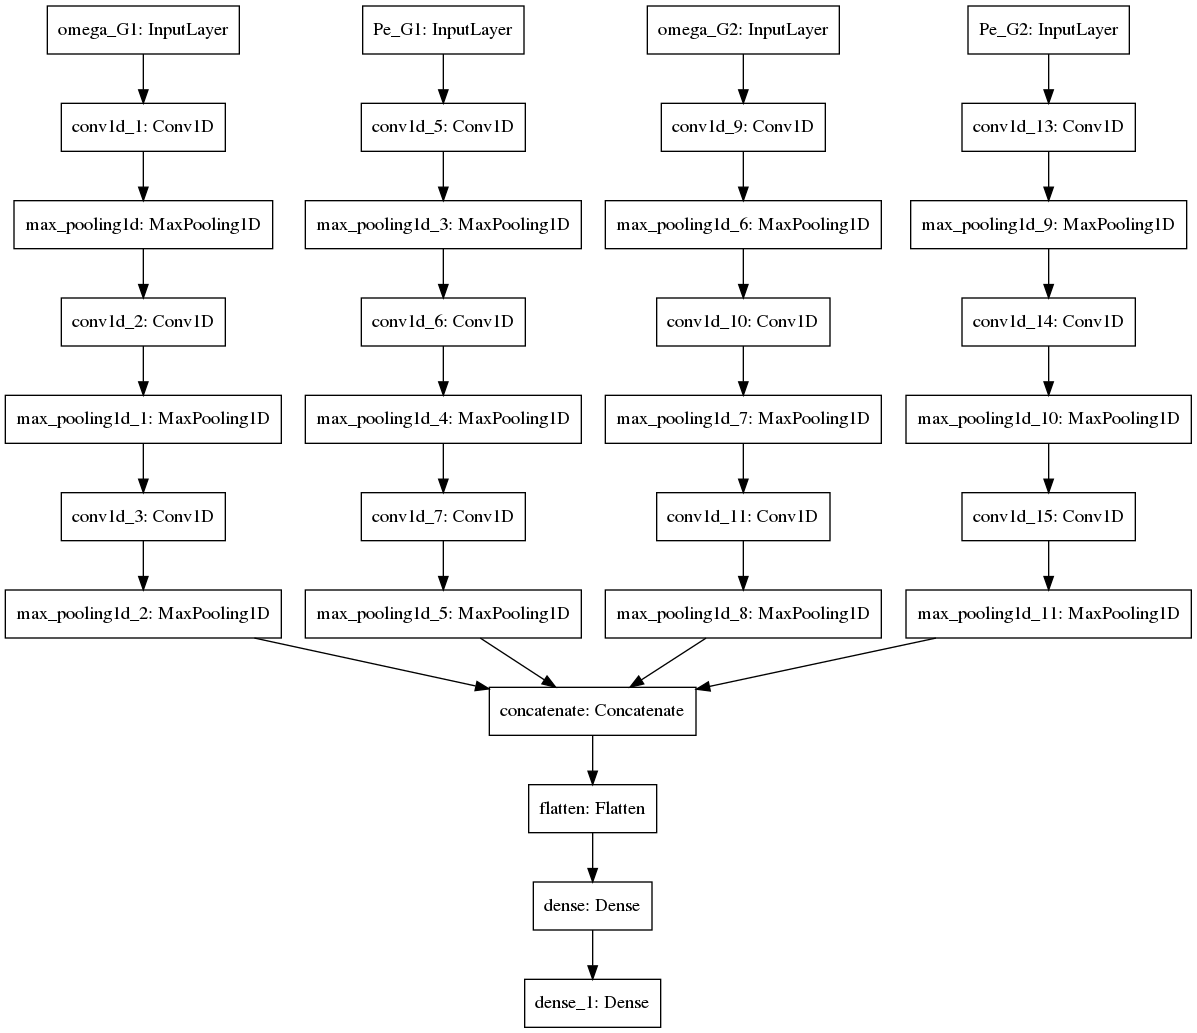

In [4]:
keras.utils.plot_model(model, show_shapes=False, dpi=96)

### Constant inertia
Estimation of the value of inertia for all the generators in the IEEE14 network. The neural network has been trained using data from the generators in the <tt>generator_IDs</tt> list.

In [7]:
generator_IDs_to_predict = [1, 3]
generator_IDs_map = {1: 1, 3: 2}
window_dur = 60
window_step = 10
H_value = 8.5
idx = 0
data_file = f'{data_dirs[idx]}/H_{H_value:.3f}.h5'
var_names = [var_name.format(gen_id) for gen_id in generator_IDs_to_predict \
             for var_name in network_parameters['var_names']]
if np.all(generator_IDs_to_predict == generator_IDs):
    data_mean = {var_name: x_train_mean[i] for i,var_name in enumerate(var_names)}
    data_std = {var_name: x_train_std[i] for i,var_name in enumerate(var_names)}
else:
    data_mean = {}
    data_std = {}
    for gen_id in generator_IDs_to_predict:
        for i,var_name_fmt in enumerate(network_parameters['var_names']):
            var_name = var_name_fmt.format(gen_id)
            j = (generator_IDs_map[gen_id] - 1) * 2 + i
            data_mean[var_name] = x_train_mean[j]
            data_std[var_name] = x_train_std[j]
    data_mean = None
#     data_std = None
t, data, data_normalized, data_sliding, _ = load_data_slide([data_file],
                                                            var_names,
                                                            data_mean,
                                                            data_std,
                                                            window_dur,
                                                            window_step,
                                                            verbose=True)

if not np.all(generator_IDs_to_predict == generator_IDs):
    for src,dst in generator_IDs_map.items():
        for var_name in network_parameters['var_names']:
            data_sliding[var_name.format(dst)] = data_sliding.pop(var_name.format(src))

dt = np.diff(t[:2])[0]
time, inertia, _ = predict(model, data_sliding, window_step, dt)

data_mean = {'omega_G1': 0.9999910105276009, 'Pe_G1': 232592849.53608653, 'omega_G3': 0.9999910094085612, 'Pe_G3': 1066.7621484237452}
Window size: 600 samples
Number of trials: 3540


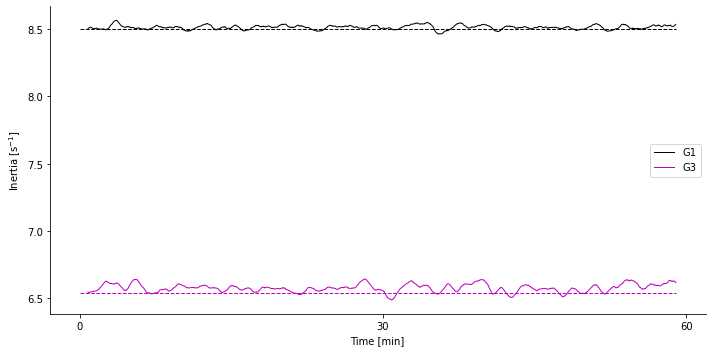

In [8]:
default_H = {
    1: 10.296 / 2,
    2: 13.08 / 2,
    3: 13.08 / 2,
    6: 10.12 / 2,
    8: 10.12 / 2
}

fig,ax = plt.subplots(1, 1, figsize=[10,5])
cmap = {1: 'k', 2: 'g', 3: 'm', 6: 'r', 8: 'c'}
for i,gen_id in enumerate(generator_IDs_to_predict):
    ax.plot(time / 60, inertia[:,i], label=f'G{gen_id}', color=cmap[gen_id], lw=1)
    if gen_id == generator_IDs[idx]:
        ax.plot(time[[0,-1]] / 60, H_value + np.zeros(2), '--', lw=1, color=cmap[gen_id])
    else:
        ax.plot(time[[0,-1]] / 60, default_H[gen_id] + np.zeros(2), '--', lw=1, color=cmap[gen_id])
ax.legend(loc='best')
ax.set_xlabel('Time [min]')
ax.set_ylabel(r'Inertia [s$^{-1}$]')
ax.set_xticks(np.arange(time[0], time[-1]/60+10, 30))
for side in 'right', 'top':
    ax.spines[side].set_visible(False)
# ax.set_ylim([5,10])
fig.tight_layout()